In [1]:
import numpy as np
import pandas as pd
import math as math
from matplotlib import pyplot as plt
from sklearn import model_selection, preprocessing
%matplotlib inline

## Исследование данных

#### Загрузка датасетов:

In [2]:
DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

train_data=pd.read_csv(DATASET_PATH)
test_data=pd.read_csv(TEST_DATASET_PATH)

Посмотрим на структуру тренировочного датасета:

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


Видим, что данные составляют 10000 записей, включают в себя типы int64, float64 и object. Часть признаков присутствует не полностью, в частности, LifeSquare (жилая площадь) и HealtCare_1 (показатель охраны здоровья)

Статистика тренировочного датасета:

In [4]:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


Видим, что даные явно некорректны, и содержат аномальные значения. В частности, есть дома с нулевым количеством комнат, год представлен в неудобоваримом формате, в KitchenSquare попал год постройки дома и т.д.

Посмотрим на структуру тестового датасета:

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


Видим, что данные составляют 5000 записей, типы данных идентичны типам из тренировочного датасета. LifeSquare и HealthCare также присутствуют не полностью.

Статистика тестового датасета:

In [6]:
test_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,5000.0,8412.595400,4832.674037,1.000000,4221.750000,8320.500000,12598.250000,16795.000000
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.910000,0.838594,0.000000,1.000000,2.000000,2.000000,17.000000
Square,5000.0,56.449500,19.092787,1.378543,41.906231,52.921340,66.285129,223.453689
LifeSquare,3959.0,36.158810,17.825287,0.333490,23.092026,32.925087,45.174091,303.071094
KitchenSquare,5000.0,5.976800,9.950018,0.000000,1.000000,6.000000,9.000000,620.000000
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,78.000000
HouseFloor,5000.0,12.601000,6.789213,0.000000,9.000000,12.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867


Ситуация аналогична тренировочному датасету.

Отобразим распределение целевой переменной 'Price':

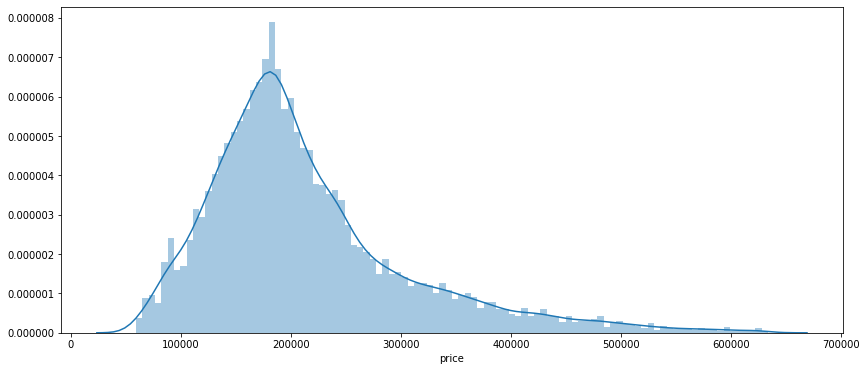

In [7]:
import seaborn as sns
from scipy.stats import lognorm
plt.figure(figsize = (14, 6))
sns.distplot(train_data['Price'], bins=100, kde=True)
plt.xlabel('price')
plt.show()

Визуально распределение цены имеет признак логнормального распределения.


Для дальнейшей работы необходимо преобразовать данные.


### Преобразование данных:

#### Преобразование данных будем выполнять по следующему алгоритму:
#### 1. Изменение типа данных и оцифровка категориальных признаков
#### 2. Заполнение пропущенных значений реалистичными данными
#### 3. Обработка выбросов и аномальных значений

##### 1. Изменение типа данных и оцифровка категориальных признаков:

Посмотрим, что за данные хранятся в object-столбцах:

In [8]:
object_data = train_data.select_dtypes(include='object')
object_data_columns = object_data.columns
object_data_columns

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

In [9]:
train_data['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [10]:
train_data['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [11]:
train_data['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Во всех столбцах типа 'object' находятся значения, соответствующие какой-то категории. Можно заменить их на числовые.

Определим функцию замены:

In [12]:
def change_category_to_number(data):
    '''Функция получает в качестве параметра датафрейм,
        определяет в нем признаки с типом "object",
        применяя OrdinalEncoder, переводит категориальные признаки в числовые с типом "int64",
        устанавливает значения этих признаков в исходный датафрейм и возвращает его'''
    
    #получим данные из столбцов типа 'object'
    object_data = data.select_dtypes(include='object')
    object_data_columns = object_data.columns
    
    #преобразуем категориальные признаки в числовые
    encoder = preprocessing.OrdinalEncoder(dtype='int64')
    encoder.fit(object_data)
    object_data = encoder.transform(object_data)
    
    #полученные значения запишем в исходный датафрейм
    data[object_data_columns] = object_data
    return data

##### 3. Заполнение пропущенных значений реалистичными данными

Пропущенные значения у нас присутствуют для 3-х признаков: LifeSquare (жилая площадь) и HealtCare_1 (показатель охраны здоровья).


In [13]:
#получим список столбцов, содержащих NaN
NaN_columns = train_data.columns[train_data.isna().any()].tolist()
NaN_columns

['LifeSquare', 'Healthcare_1']

Определим функцию для замены NaN значений на числовые:

In [19]:
def replace_NaN_with_number(data):
    
    NaN_columns = data.columns[data.isna().any()].tolist()   
    for column_name in NaN_columns:
        count_NaN_values = data[column_name].isnull().sum()
        count_values = data.shape[0]
        if count_NaN_values <= count_values * 0.4:
            data[column_name] = data[column_name].fillna(data[column_name].mean())
        else:
            data.drop(columns=[column])
    return data

In [20]:
train_data = replace_NaN_with_number(train_data)


In [21]:
train_data.head(30)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.204377
7,11993,74,2.0,80.312926,37.199645,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2.0,64.511437,37.199645,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993


In [17]:
train_data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [18]:
#заменим нулевые значения комнат на 1
data.loc[data['Rooms'] == 0, 'Rooms'] = 1

NameError: name 'data' is not defined

In [ ]:
data['Rooms'].value_counts()

In [ ]:
data["LifeSquare"].fillna(0, inplace=True)
data[['Square','LifeSquare']]

In [ ]:
data.loc[data['LifeSquare'] == 0, 'LifeSquare'] = data['LifeSquare'].mean()
data[['Square','LifeSquare']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)